# CSE 6748 Capstone Project
## Asurion Appliance Repair 

Module 1: Image Classification

Kevin Tong in collaboration with Min Fang, Xionggang Zhang

## Import packages

In [21]:
import argparse
import asyncio
import gc
import os
import time
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from multiprocessing import (
    cpu_count,
    Pool
)

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
# from google.colab import drive


## Define helper functions

In [2]:
# mount google drive and add workdir
# drive.mount('/content/drive')
# PROJECT_ROOT = "/content/drive/MyDrive/OMSA/CSE6748/data_image_classification"
PROJECT_ROOT = "/mnt/c/Users/kevto/OneDrive/Classwork/OMSA/Coursework/CSE6748/data_image_classification"
wdir = Path(PROJECT_ROOT)
os.chdir(wdir)
!ls

classification_dataset_annotations.xlsx  data  temp


In [3]:
# parse summary file & relate images to paths
MODULE_1_DATA_DIR = wdir.joinpath("data")
df_images = pd.read_excel("classification_dataset_annotations.xlsx")
df_images["image_path"] = str(MODULE_1_DATA_DIR) + df_images.example.str.slice(4)

# filter specific outliers identified in manual review
files_to_filter = [
    "Laundry/SJ48484064/David Garofalo.png", 
    "SJ48309649/signature-next-steps-signature_32d5e8a7-c1e3-4f54-ac7f-9959a002d016.png", 
    "SJ48476945/signature-next-steps-signature_e1347dd4-bdf5-44a5-8c73-a10673da8c87.png",
    "SJ48173895/signature-next-steps-signature_c11ab8f2-b575-4b56-9901-2feae72382a2.png"
]
filepath_filters = []
for filepath in files_to_filter:
  filepath_filters.append(
      df_images.example.str.contains(filepath)
  )
apply_filepath_filter = np.logical_or.reduce(filepath_filters)
df_images_filtered = df_images.loc[~apply_filepath_filter].copy()

del df_images
del filepath, files_to_filter, filepath_filters
gc.collect()

3471

In [ ]:
# # optional: preview erroneous images
# for _, row in df_images.loc[apply_filepath_filter].iterrows():
#   with Image.open(row["image_path"]) as im:
#     im.show()

## Load and preprocess images
Normalize, center, and standardize the data


In [4]:
# run in local runtime w/ Python 3.9
async def load_transform_image(image_path):
  # read image data and convert to greyscale
  # TODO: Handle images with different color channel schemas robustly 
  with Image.open(image_path).convert("L") as im:
    img = np.array(im).astype("float32") / 255  # normalize image data
    im.close()
  
  # center and standardize image data
  img = (img - img.mean()) / img.std()  

  return img

idx_aws, image_data = [], {}

# create iterable of awaitable coroutines
for i, row in df_images_filtered.iterrows():
  idx_aws.append((i, load_transform_image(row.image_path)))
  del i, row

# iterate through coroutines and log results
for i, future in tqdm.tqdm(idx_aws):
  image_data[i] = await future
  del i, future

df_images_filtered.loc[:, "image_data"] = image_data.values()

del idx_aws, image_data
gc.collect()

100%|█████████████████████████████████████████████████| 3302/3302 [00:31<00:00, 105.37it/s]


0

In [121]:
## save / load preprocessed data
TEMPDATA_IMG = wdir.joinpath("temp").joinpath("df_filtered_images.pck")

# # save preprocessed data
# if not os.path.exists("temp"):
#     os.mkdir("temp")
# df_images_filtered.to_pickle(TEMPDATA_IMG)

# # load preprocessed data (if available)
# if os.path.exists(TEMPDATA_IMG):
#   df_images_filtered = pd.read_pickle(TEMPDATA_IMG)

In [7]:
# filter for image sizes

# check input image dimensions
dimensions = {}
for x in df_images_filtered.image_data:
  xdim = x.shape
  if xdim not in dimensions.keys():
    dimensions[x.shape] = 1
  else:
    dimensions[x.shape] += 1

print("Unfiltered image dimensions:", "="*30, sep="\n")
[print(k, ":", v) for k, v in dimensions.items()]

# From inspection, we see that 1080 x 810 px is the most common image dimension
# and thus focus our project on the this image dimension. This presents an 
# opportunity for future work in enhancing process robustness
# to varying input image sizes

# subset input data
filter_image_dims = df_images_filtered.image_data.apply(np.shape) == (1080, 810)
df_images_filtered = df_images_filtered.loc[filter_image_dims].copy()

del dimensions, x, xdim, filter_image_dims
gc.collect()

Unfiltered image dimensions:
(1080, 810) : 3211
(810, 1080) : 57
(1080, 549) : 14
(1080, 546) : 6
(1080, 1080) : 7
(1080, 547) : 3
(1080, 552) : 2
(1920, 1080) : 2


515

# Split data

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


In [142]:
RANDOM_SEED = 42
PCT_TRAIN, PCT_VAL, PCT_TEST = 0.7, 0.2, 0.1

N_IMAGES = df_images_filtered.shape[0]
N_TRAIN = round(N_IMAGES * PCT_TRAIN)
N_VAL = round(N_IMAGES * PCT_VAL)
N_TEST = round(N_IMAGES * PCT_TEST)
assert N_TRAIN + N_VAL + N_TEST == N_IMAGES

X = df_images_filtered.image_data.values
y = df_images_filtered.label

# find left singular vectors
left_singular_vectors = np.array([])
for i in tqdm.tqdm(range(X.shape[0])):
  x = X[i]
  u, s, vt = np.linalg.svd(x)
  # reduce precision to avoid OOM errors and save results 
  if left_singular_vectors.shape[0] == 0:
    left_singular_vectors = u[0].astype(np.half)
  else:
    left_singular_vectors = np.vstack(
        (left_singular_vectors, u[0].astype(np.half))
        )
  del u, s, vt, x
  if i % 50 == 0: gc.collect()  # periodically free memory
us = left_singular_vectors

100%|██████████████████████████████████████████████████| 3211/3211 [18:53<00:00,  2.83it/s]


In [143]:
## save / load preprocessed data
TEMPDATA_SVD = wdir.joinpath("temp").joinpath("left_singular_vectors.npy")

# save preprocessed data
if not os.path.exists("temp"): os.mkdir("temp")
np.save(TEMPDATA_SVD, left_singular_vectors)

# # load preprocessed data (if available)
# if os.path.exists(TEMPDATA_SVD):
#   us = left_singular_vectors = np.load(TEMPDATA_SVD, allow_pickle=True)

In [150]:
# # split the data
# X_train, X_val_test, y_train, y_val_test = \
#   train_test_split(us, y, 
#                    test_size=(PCT_VAL + PCT_TEST),
#                    random_state=RANDOM_SEED)
  
# X_val, X_test, y_val, y_test = \
#   train_test_split(X_val_test, y_val_test,
#                    train_size=N_VAL, random_state=RANDOM_SEED)
  
X_train, X_test, y_train, y_test = \
train_test_split(us, y, 
                  test_size=(PCT_TEST),
                  random_state=RANDOM_SEED)

In [162]:
# perform gridsearch to tune model hyperparameters
param_grid = {
    "max_depth": np.arange(10,110,10),
    "min_samples_split": np.arange(5,55,5),
              }
base_estimator = RandomForestClassifier(random_state=RANDOM_SEED)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, 
                         resource="n_estimators", max_resources=int(1e3)
                         ).fit(X_train, y_train)
sh.best_estimator_

RandomForestClassifier(max_depth=70, min_samples_split=40, n_estimators=960,
                       random_state=42)

In [167]:
## save / load classifier model
import joblib
TEMPDATA_RFCLF = wdir.joinpath("temp").joinpath("rf_classifier.joblib")

# save classifier model
if not os.path.exists("temp"): os.mkdir("temp")
joblib.dump(sh, TEMPDATA_RFCLF)

# # load classifier model (if available)
# if os.path.exists(TEMPDATA_RFCLF):
#   sh = joblib.load(TEMPDATA_RFCLF)

['/mnt/c/Users/kevto/OneDrive/Classwork/OMSA/Coursework/CSE6748/data_image_classification/temp/rf_classifier.joblib']

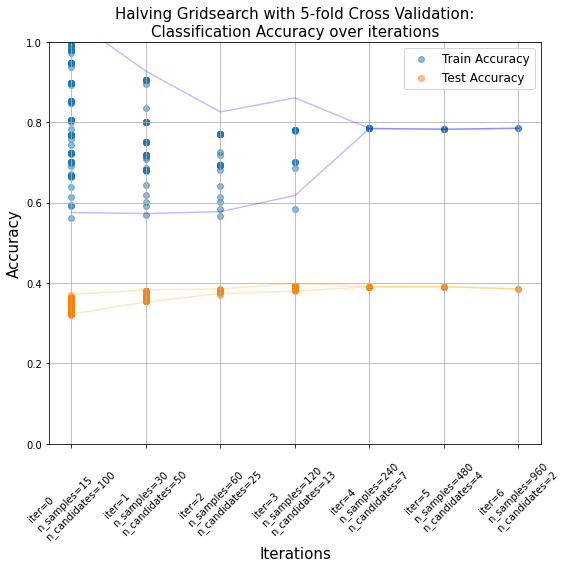

In [339]:
# visualize gridsearch results

temp = pd.DataFrame(sh.cv_results_)

# report mean and standard deviation of test and train scores across iterations
mean_train = temp.groupby("iter").mean_train_score.mean()
mean_test = temp.groupby("iter").mean_test_score.mean()
std_train = temp.groupby("iter").mean_train_score.std()
std_test = temp.groupby("iter").mean_test_score.std()

# visualization
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=temp.iter, y=temp.mean_train_score, 
           label="Train Accuracy", alpha=0.5)
ax.plot(mean_train + 2*std_train, c="blue", alpha=0.25)
ax.plot(mean_train - 2*std_train, c="blue", alpha=0.25)

ax.scatter(x=temp.iter, y=temp.mean_test_score, 
           label="Test Accuracy", alpha=0.5)
ax.plot(mean_test + 2*std_test, c="orange", alpha=0.25)
ax.plot(mean_test - 2*std_test, c="orange", alpha=0.25)

labels = [
    f"iter={i}\nn_samples={sh.n_resources_[i]}\nn_candidates={sh.n_candidates_[i]}"
    for i in range(sh.n_iterations_)
]

# annotate figure
ax.set_xticks(range(sh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Halving Gridsearch with 5-fold Cross Validation:\nClassification Accuracy over iterations", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylim(0, 1)
plt.tight_layout()
ax.grid()
ax.legend(fontsize=12)
plt.show()

In [350]:
temp.iloc[-2].mean_fit_time

32.61927318572998

In [311]:
print(sh.best_estimator_.score(X_train, y_train))
print(sh.best_estimator_.score(X_test, y_test))

0.7902388369678089
0.6666666666666666
0.4409937888198758


## Repeat experiment for first two eigenvectors

In [325]:
RANDOM_SEED = 42
PCT_TRAIN, PCT_VAL, PCT_TEST = 0.7, 0.2, 0.1

N_IMAGES = df_images_filtered.shape[0]
N_TRAIN = round(N_IMAGES * PCT_TRAIN)
N_VAL = round(N_IMAGES * PCT_VAL)
N_TEST = round(N_IMAGES * PCT_TEST)
assert N_TRAIN + N_VAL + N_TEST == N_IMAGES

X = df_images_filtered.image_data.values
y = df_images_filtered.label

# find left singular vectors
left_singular_vectors = np.array([])
for i in tqdm.tqdm(range(X.shape[0])):
  x = X[i]
  u, s, vt = np.linalg.svd(x)
  # reduce precision to avoid OOM errors and save results 
  if left_singular_vectors.shape[0] == 0:
    left_singular_vectors = np.hstack(
        (u[0].astype(np.half), u[1].astype(np.half))
        )
  else:
    left_singular_vectors = np.vstack(
        (left_singular_vectors, 
         np.hstack((u[0].astype(np.half), u[1].astype(np.half)))
        )
      )
  del u, s, vt, x
  if i % 50 == 0: gc.collect()  # periodically free memory
us2 = left_singular_vectors2

100%|██████████████████████████████████████████████████| 3211/3211 [19:00<00:00,  2.82it/s]


In [327]:
## save / load preprocessed data
TEMPDATA_SVD2 = wdir.joinpath("temp").joinpath("left_singular_vectors2.npy")

# save preprocessed data
if not os.path.exists("temp"): os.mkdir("temp")
np.save(TEMPDATA_SVD, left_singular_vectors2)

# # load preprocessed data (if available)
# if os.path.exists(TEMPDATA_SVD):
#   us2 = left_singular_vectors2 = np.load(TEMPDATA_SVD2, allow_pickle=True)

In [330]:
# split the data
X_train, X_test, y_train, y_test = \
train_test_split(us2, y, 
                  test_size=(PCT_TEST),
                  random_state=RANDOM_SEED)

In [331]:
# perform gridsearch to tune model hyperparameters
param_grid = {
    "max_depth": np.arange(10,110,10),
    "min_samples_split": np.arange(5,55,5),
              }
base_estimator = RandomForestClassifier(random_state=RANDOM_SEED)
sh2 = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, 
                         resource="n_estimators", max_resources=int(1e3)
                         ).fit(X_train, y_train)
sh2.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=25, n_estimators=960,
                       random_state=42)

In [333]:
print(sh2.best_estimator_.score(X_train, y_train))
print(sh2.best_estimator_.score(X_test, y_test))

0.6839736933194878
0.4409937888198758


In [334]:
test_clf = RandomForestClassifier(n_estimators=int(1e4), max_depth=10, min_samples_split=25, random_state=RANDOM_SEED)
test_clf.fit(X_train, y_train)
test_clf.score(X_test, y_test)

0.4409937888198758

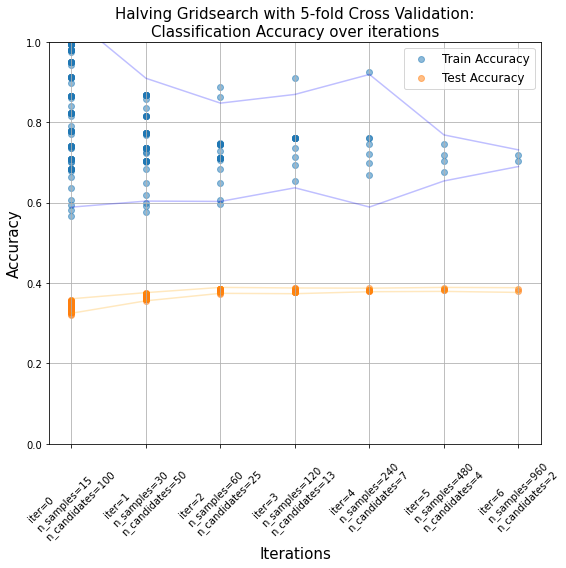

In [336]:
# visualize gridsearch results

temp = pd.DataFrame(sh2.cv_results_)

# report mean and standard deviation of test and train scores across iterations
mean_train = temp.groupby("iter").mean_train_score.mean()
mean_test = temp.groupby("iter").mean_test_score.mean()
std_train = temp.groupby("iter").mean_train_score.std()
std_test = temp.groupby("iter").mean_test_score.std()

# visualization
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=temp.iter, y=temp.mean_train_score, 
           label="Train Accuracy", alpha=0.5)
ax.plot(mean_train + 2*std_train, c="blue", alpha=0.25)
ax.plot(mean_train - 2*std_train, c="blue", alpha=0.25)

ax.scatter(x=temp.iter, y=temp.mean_test_score, 
           label="Test Accuracy", alpha=0.5)
ax.plot(mean_test + 2*std_test, c="orange", alpha=0.25)
ax.plot(mean_test - 2*std_test, c="orange", alpha=0.25)

labels = [
    f"iter={i}\nn_samples={sh.n_resources_[i]}\nn_candidates={sh.n_candidates_[i]}"
    for i in range(sh.n_iterations_)
]

# annotate figure
ax.set_xticks(range(sh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Halving Gridsearch with 5-fold Cross Validation:\nClassification Accuracy over iterations", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylim(0, 1)
plt.tight_layout()
ax.grid()
ax.legend(fontsize=12)
plt.show()

In [338]:
## save / load classifier model
TEMPDATA_RFCLF2 = wdir.joinpath("temp").joinpath("rf_classifier2.joblib")

# save classifier model
if not os.path.exists("temp"): os.mkdir("temp")
joblib.dump(sh2, TEMPDATA_RFCLF2)

['/mnt/c/Users/kevto/OneDrive/Classwork/OMSA/Coursework/CSE6748/data_image_classification/temp/rf_classifier2.joblib']